In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.spatial import distance

In [2]:
class node:
    def __init__(self, x, y, xPre, yPre, dist=0, indPre=0):
        self.x = [x]
        self.y = [y]
        self.xPre = [xPre]
        self.yPre = [yPre]
        self.dist = [dist]
        self.indPre = [indPre]
        
class path:
    def __init__(self, x, y):
        self.x = [x]
        self.y = [y]

In [3]:
def line_check(axis1, axis2, gray_img):
    limit_range = 2
    if axis1[1] > axis2[1]:
        y_list = np.arange(int(axis2[1])-limit_range,int(axis1[1])+limit_range)
    elif axis1[1] < axis2[1]:
        y_list = np.arange(int(axis1[1])-limit_range, int(axis2[1])+limit_range)
    else:
        y_list = np.arange(int(axis1[1])-limit_range, int(axis1[1])+limit_range)
        
    if axis1[0] > axis2[0]:
        x_list = np.arange(int(axis2[0])-limit_range,int(axis1[0])+limit_range)
    elif axis1[0] < axis2[0]:
        x_list = np.arange(int(axis1[0])-limit_range, int(axis2[0])+limit_range)
    else:
        x_list = np.arange(int(axis1[0])-limit_range, int(axis1[0])+limit_range)
    
    for y in y_list:
        for x in x_list:
            gray_num = gray_img[y][x][0]
            if gray_num <= 205:
                return 1
    return 0

def check_in_boundary(axis, gray_img, limit_range):
    y_list = np.arange(int(axis[1])-limit_range, int(axis[1])+limit_range)
    x_list = np.arange(int(axis[0])-limit_range, int(axis[0])+limit_range)
    for y in y_list:
        for x in x_list:
            gray_num = gray_img[y][x][0]   
            if gray_num <= 205:
                return 1
    return 0

def recursive_refine(refining_path):
    length = len(refining_path[0])
    min_angle = 9999999
    min_angle_index = 0
    
    for i in range(1, length):
        x_diff = refining_path[0][0] - refining_path[0][i]
        y_diff = refining_path[1][0] - refining_path[1][i]
        angle = abs(math.atan(y_diff/x_diff) * (180/math.pi))
        
        CheckInBound = check_in_boundary([refining_path[0][i], refining_path[1][i]], gray_img, 15)
        if CheckInBound == 1:
            continue
        
        if min_angle > angle:
            min_angle = angle
            min_angle_index = i
            
    refined_path[0].append(refining_path[0][0])
    refined_path[1].append(refining_path[1][0])
    refining_path = [refining_path[0][min_angle_index:], refining_path[1][min_angle_index:]]
    
    if len(refining_path[0][min_angle_index:]) != 1:
        recursive_refine(refining_path)
    
def PathRefine(path):
    global refined_path
    pathLength = len(path.x)
    vector_x_pos = []
    vector_y_pos = []

    for i in range(pathLength):
        vector_x_pos.append(path.x[i])
        vector_y_pos.append(path.y[i])
    
    tempPath_refine = [vector_x_pos, vector_y_pos]
    refined_path = [[], []]        
    recursive_refine(tempPath_refine)
    
    return refined_path

In [4]:
def RRT(node, path, start, end, range_num):
    for i in range(1, range_num):
        x_rand = [start[0] + (end[0]-start[0])* np.random.rand(1), start[1] + (end[1]-start[1])* np.random.rand(1)]
#        x_rand = [robot[0] + (goal[0]-robot[0])* np.random.rand(1), robot[1] + (goal[1]-robot[1])* np.random.rand(1)]
        
        min_dist = 9999999
        near_iter = 0
        N = len(node.x)
   
        for j in range(N):
            x_near = [node.x[j], node.y[j]]
            dist = distance.euclidean(x_rand, x_near)
            if min_dist > dist:
                min_dist = dist
                near_iter = j
            
        x_near = [node.x[near_iter], node.y[near_iter]]
            
        near_rand = [x_rand[0]-x_near[0], x_rand[1]-x_near[1]]
        normlized = [near_rand[0] / distance.euclidean(x_rand, x_near)*stepsize, near_rand[1] / distance.euclidean(x_rand, x_near)*stepsize]
        x_new = [x_near[0] + normlized[0], x_near[1] + normlized[1]] 
        
        CheckInBoundNew = check_in_boundary(x_new, gray_img, 5)
        LineCheck = line_check(x_new, x_near, gray_img)
        
        if CheckInBoundNew == 1 or LineCheck == 1:
            continue
            
        ax.plot([x_near[0], x_new[0]], [x_near[1], x_new[1]], 'b-', linewidth=2)
        node.x.append(x_new[0])
        node.y.append(x_new[1])
        node.xPre.append(x_near[0])
        node.yPre.append(x_near[1])
        node.dist.append(distance.euclidean(x_new, x_near))
        node.indPre.append(near_iter)

        if distance.euclidean(x_new, end) < 0.001:
            break 

    if True:
        path.x[0] = end[0]
        path.y[0] = end[1]
        path.x.append(node.x[-1])
        path.y.append(node.y[-1])
        path_index = node.indPre[-1]

        while True:
            path.x.append(node.x[path_index])
            path.y.append(node.y[path_index])
            path_index = node.indPre[path_index]
            if path_index == 0:
                break

        path.x.append(start[0])
        path.y.append(start[1])
        Range_Num = len(path.x)
        for j in range(1, Range_Num):
            ax.plot([path.x[j], path.x[j-1]], [path.y[j], path.y[j-1]], 'r:', linewidth=2)

    else:
        print('no path to end')

In [5]:
def set_params():
    global stepsize, robot, goal, waypoint_1, waypoint_2, waypoint_3, v, v2, v3, v4, pos, pos2, pos3, pos4
    stepsize = 10
    robot = [1770, 500]
    goal = [540, 100]
    waypoint_1 = [1150, 1650]
    waypoint_2 = [600, 1400]
    waypoint_3 = [210, 1180]
    
    v = node(robot[0], robot[1], robot[0], robot[1])
    v2 = node(waypoint_1[0], waypoint_1[1], waypoint_1[0], waypoint_1[1])
    v3 = node(waypoint_2[0], waypoint_2[1], waypoint_2[0], waypoint_2[1])
    v4 = node(waypoint_3[0], waypoint_3[1], waypoint_3[0], waypoint_3[1])

    pos = path(0, 0)
    pos2 = path(0, 0)
    pos3 = path(0, 0)
    pos4 = path(0, 0)

In [6]:
def station():
    set_params()
    global img, gray_img, fig, ax
    img = cv2.imread('school.pgm')

    gray_img = np.asarray(img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    binary = cv2.bitwise_not(binary)

    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_title('Local map with an obstacle and line constraints', fontsize=40)

    ax.set_xlim([0, 1900])
    ax.set_ylim([0, 1750])
    
    ax.plot(robot[0], robot[1], 'rd', markersize = 5, linewidth=1)
    ax.plot(waypoint_1[0], waypoint_1[1], 'gd', markersize = 5, linewidth=1)
    ax.plot(waypoint_2[0], waypoint_2[1], 'gd', markersize = 5, linewidth=1)
    ax.plot(waypoint_3[0], waypoint_3[1], 'gd', markersize = 5, linewidth=1)
    ax.plot(goal[0], goal[1], 'rd', markersize = 5, linewidth=1)

    RRT(v, pos, robot, waypoint_1, 5001)
    RRT(v2, pos2, waypoint_1, waypoint_2, 2001)
    RRT(v3, pos3, waypoint_2, waypoint_3, 1001)
    RRT(v4, pos4, waypoint_3, goal, 5001)

    Final_1 = PathRefine(pos)
    Final_2 = PathRefine(pos2)
    Final_2[0].pop()
    Final_2[1].pop()
    Final_3 = PathRefine(pos3)
    Final_3[0].pop()
    Final_3[1].pop()
    Final_4 = PathRefine(pos4)
    Final_4[0].pop()
    Final_4[1].pop()

    Final_path = []
    Final_path.append(Final_4[0] + Final_3[0] + Final_2[0] + Final_1[0])
    Final_path.append(Final_4[1] + Final_3[1] + Final_2[1] + Final_1[1])

    final_length = len(Final_path[0])

    for i in range(final_length-1):
        ax.plot([Final_path[0][i], Final_path[0][i+1]], [Final_path[1][i], Final_path[1][i+1]],  'k--', linewidth=2)
    
    ax.imshow(img)

C:\Users\tjdgu\anaconda3\envs\tf\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


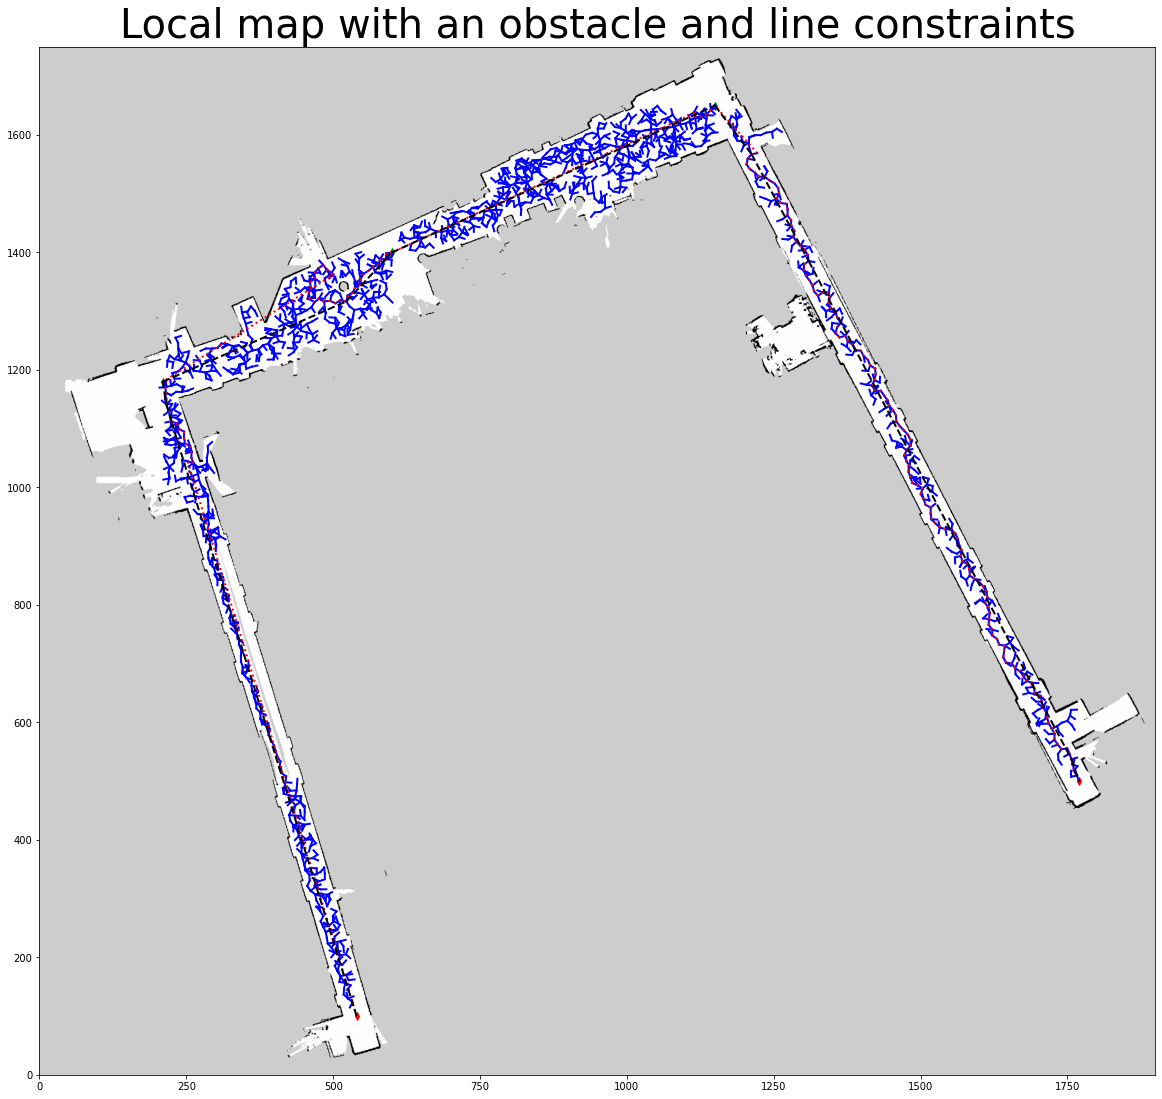

In [7]:
if __name__ == "__main__":
    station()    